In [377]:
%pwd
%cd template
%pwd

[Errno 2] No such file or directory: 'template'
/mnt/d/src/learn-ml/template


'/mnt/d/src/learn-ml/template'

In [378]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import set_config
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Constants
data_file_path = "./data/home-data-for-ml-course/train.csv"
test_size = 0.2
val_size = 0.2
random_state = 0
set_config(transform_output="pandas")

# Load data
df = pd.read_csv(data_file_path)

# Target and features
target = "SalePrice"
y = df.SalePrice

# All numeric without missing values
features = list(set(df.columns) - set(["SalePrice"]))
X_orig = df[features]
X = X_orig.copy()

In [379]:
# Numerical vs categorical features
categorical_cols = list(X.select_dtypes(include=["object"]).columns)
numerical_cols = list(set(X.columns) - set(categorical_cols))
area_cols = ["LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea"]

In [380]:
# Handle missing values by replacing with mean or mode
cols_with_missing_vals = X.isnull().sum()
cols_with_missing_vals = cols_with_missing_vals[cols_with_missing_vals > 0].index

cols_with_missing_vals_categorical = list(set(categorical_cols).intersection(set(cols_with_missing_vals)))
cols_with_missing_vals_numerical = list(set(numerical_cols).intersection(set(cols_with_missing_vals)))

# Mask numerical nulls with mean
for col in cols_with_missing_vals_numerical:
    print(f"Replacing nulls in {col} with mean")
    X[col] = X[col].mask(X[col].isnull(), X[col].mean())

# Mask categorical nulls with mode
for col in cols_with_missing_vals_categorical:
    print(f"Replacing nulls in {col} with mode")
    X[col] = X[col].mask(X[col].isnull(), X[col].mode().values[0])

assert np.all(X.isnull().sum() == 0), "Null values are still present in the data"

Replacing nulls in GarageYrBlt with mean
Replacing nulls in LotFrontage with mean
Replacing nulls in MasVnrArea with mean
Replacing nulls in BsmtQual with mode
Replacing nulls in Fence with mode
Replacing nulls in BsmtExposure with mode
Replacing nulls in GarageQual with mode
Replacing nulls in FireplaceQu with mode
Replacing nulls in GarageCond with mode
Replacing nulls in BsmtFinType1 with mode
Replacing nulls in BsmtFinType2 with mode
Replacing nulls in GarageType with mode
Replacing nulls in BsmtCond with mode
Replacing nulls in Alley with mode
Replacing nulls in Electrical with mode
Replacing nulls in GarageFinish with mode
Replacing nulls in MiscFeature with mode
Replacing nulls in PoolQC with mode
Replacing nulls in MasVnrType with mode


In [381]:
# Ordinal-encode categorical variables
# pd.options.mode.chained_assignment = None

for col in categorical_cols:
    values, index = pd.factorize(X.loc[:, col])
    # Disable chained assignment for this line
    X[col] = values

# pd.options.mode.chained_assignment = "warn"

In [382]:
# Standardize all numerical features
cols = numerical_cols
X[cols] = (X[cols] - X[cols].mean()) / X[cols].std()

# Feature Importance

In [383]:
# Use mutual information to select features
from sklearn.feature_selection import mutual_info_regression

# Compute mutual information scores
mi_scores = pd.Series(
    data=mutual_info_regression(X[numerical_cols], y, discrete_features=False),
        index=numerical_cols)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

OverallQual      0.562003
GrLivArea        0.483611
TotalBsmtSF      0.368405
GarageArea       0.366392
YearBuilt        0.361132
GarageCars       0.344388
1stFlrSF         0.310352
GarageYrBlt      0.293338
MSSubClass       0.275711
FullBath         0.251914
YearRemodAdd     0.251470
TotRmsAbvGrd     0.215539
LotFrontage      0.196571
2ndFlrSF         0.195257
Fireplaces       0.164662
LotArea          0.159730
OpenPorchSF      0.153535
BsmtFinSF1       0.153435
OverallCond      0.123432
BsmtUnfSF        0.118478
MasVnrArea       0.099395
WoodDeckSF       0.098022
HalfBath         0.085448
BedroomAbvGr     0.068820
EnclosedPorch    0.033385
KitchenAbvGr     0.030238
ScreenPorch      0.022699
BsmtFullBath     0.017872
LowQualFinSF     0.016614
MiscVal          0.012866
BsmtHalfBath     0.010399
3SsnPorch        0.007544
BsmtFinSF2       0.000000
Id               0.000000
YrSold           0.000000
MoSold           0.000000
PoolArea         0.000000
dtype: float64

<Axes: ylabel='None'>

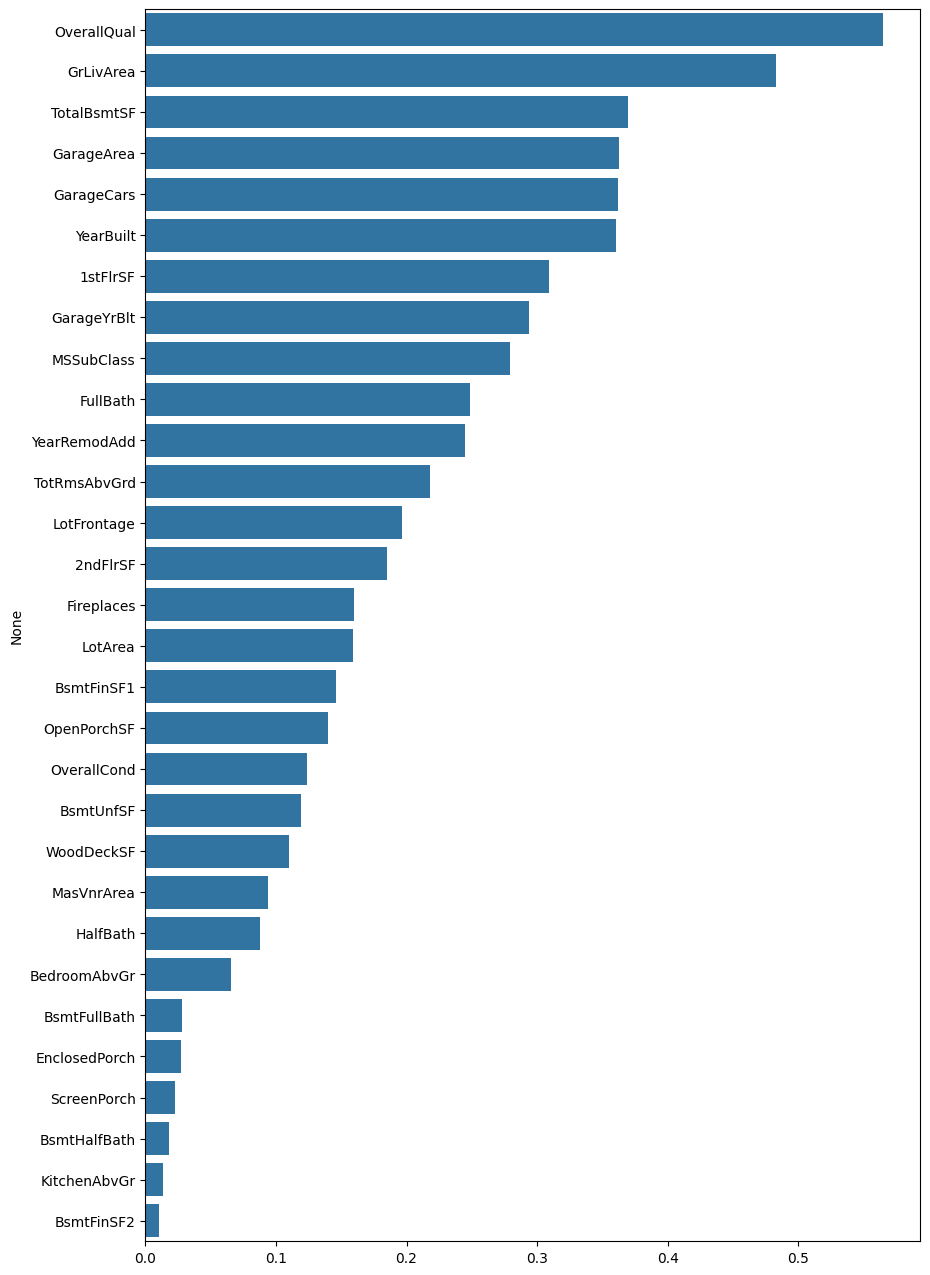

In [370]:
# Plot mutual information scores
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(10,16))
N = 30
sns.barplot(x=mi_scores.values[0:N], y=mi_scores.index[0:N])

# Creating Features

In [371]:
# Create some features
# LotFrontage: Linear feet of street connected to property
# LotArea: Lot size in square feet
# MasVnrArea: Masonry veneer area in square feet
# # BsmtFinSF1: Type 1 finished square feet
# BsmtFinSF2: Type 2 finished square feet
# BsmtUnfSF: Unfinished square feet of basement area
# TotalBsmtSF: Total square feet of basement area
# 1stFlrSF: First Floor square feet
# 2ndFlrSF: Second floor square feet
# LowQualFinSF: Low quality finished square feet (all floors)
# GrLivArea: Above grade (ground) living area square feet
# BsmtFullBath: Basement full bathrooms
# BsmtHalfBath: Basement half bathrooms
# FullBath: Full bathrooms above grade
# HalfBath: Half baths above grade
# Bedroom: Bedrooms above grade (does NOT include basement bedrooms)
# Kitchen: Kitchens above grade
# TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
# Fireplaces: Number of fireplaces
# GarageCars: Size of garage in car capacity
# GarageArea: Size of garage in square feet
# WoodDeckSF: Wood deck area in square feet
# OpenPorchSF: Open porch area in square feet
# EnclosedPorch: Enclosed porch area in square feet
# 3SsnPorch: Three season porch area in square feet
# ScreenPorch: Screen porch area in square feet
# PoolArea: Pool area in square feet
# MiscVal: $Value of miscellaneous feature
cols = ["LotArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","TotRmsAbvGrd","Fireplaces","GarageCars","GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal"]
N = len(cols)
for m in range(N):
    for n in range(m + 1, N):
        X[f"{cols[m]}/{cols[n]}"] = (X[cols[m]]/X[cols[n]]).fillna(value=0).replace(np.inf, 0)

# The above transform divides one feature by another. Other possible transforms:
# logs, counts, splitting or combining string features, a grouped feature that
# the sample belongs to

/tmp/ipykernel_1332/1648094331.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{cols[m]}/{cols[n]}"] = (X[cols[m]]/X[cols[n]]).fillna(value=0).replace(np.inf, 0)
/tmp/ipykernel_1332/1648094331.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{cols[m]}/{cols[n]}"] = (X[cols[m]]/X[cols[n]]).fillna(value=0).replace(np.inf, 0)
/tmp/ipykernel_1332/1648094331.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

# Cluster Labels as Features

In [372]:
# Use k-means to create cluster labels and use these as a feature
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto", max_iter=300).fit(X[["GrLivArea","TotalBsmtSF"]])
X["cluster"] = kmeans.predict(X[["GrLivArea","TotalBsmtSF"]])

In [373]:
# Could use the distance to cluster centroids as a feature as well
kmeans.transform(X[["GrLivArea","TotalBsmtSF"]])

,kmeans0,kmeans1,kmeans2,kmeans3,kmeans4
0,1.288956,2.825708,1.052217,0.426020,1.634366
1,0.725078,3.093017,1.610322,1.465883,0.990008
2,1.404282,2.620508,1.257065,0.251557,1.511026
3,1.375485,2.975631,0.932080,0.542933,1.862568
4,2.204136,1.702551,2.188563,0.731648,1.452609
...,...,...,...,...,...
1455,1.133311,2.774771,1.131889,0.519755,1.406395
1456,2.305152,1.430906,2.696905,1.437003,0.847279
1457,2.473724,1.520113,2.416604,0.955257,1.654584
1458,0.193298,3.570365,1.256466,1.636240,1.535030


# PCA for Feature Engineering

In [374]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [389]:
# PCA basics
# Always standardize data for PCA
pca = PCA()
cols = area_cols
X_pca = pca.fit_transform(X[cols]) # the data transformed by PCA; each column is a principal component

# pca.components_; each row is a principal component, each column is a feature
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = cols)

# pc0 represent lots with high LotFrontage and high LotArea
# pc1 represent lots with low LotFrontage and high LotArea, eg, narrow lots

# Explained variante ratio
df_ev = pd.DataFrame(data = pca.explained_variance_ratio_,
                     index = df_pca_comp.index,
                     columns = ["ev"])
# Each row is the fraction of variance explained by the corresponding principal component
# pc0 explains 23.4% of the variance

df_ev

,ev
0,0.234406
1,0.104290
2,0.089014
3,0.072869
4,0.065243
5,0.061751
6,0.058472
7,0.053911
8,0.050810
9,0.050216


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

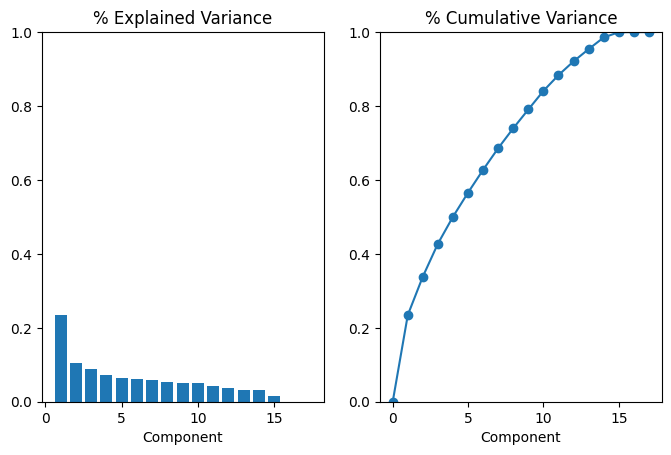

In [376]:
plot_variance(pca)

In [390]:
mi_scores = pd.Series(
    data=mutual_info_regression(X_pca, y, discrete_features=False),
        index=X_pca.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

# component 0 has a high mutual information score, so it can be used as a feature as-is


pca0     0.711476
pca1     0.152461
pca2     0.141983
pca14    0.077528
pca5     0.071719
pca8     0.059613
pca10    0.053679
pca6     0.048880
pca3     0.045488
pca11    0.041147
pca13    0.038507
pca9     0.035458
pca4     0.033864
pca12    0.028659
pca7     0.025843
pca15    0.018198
pca16    0.000095
dtype: float64

In [ ]:
# Sort the absolute value of loadings of component 0
# Loadings that have high absolute values can be used to create new features (products, ratios, etc.)
df_pca_comp.loc[0,:].abs().sort_values(ascending=False)

1stFlrSF         0.419966
TotalBsmtSF      0.415341
GrLivArea        0.380858
GarageArea       0.347815
LotFrontage      0.280083
MasVnrArea       0.271106
BsmtFinSF1       0.257733
LotArea          0.212476
OpenPorchSF      0.195991
WoodDeckSF       0.185052
BsmtUnfSF        0.138979
PoolArea         0.109961
2ndFlrSF         0.086631
EnclosedPorch    0.066874
ScreenPorch      0.065650
3SsnPorch        0.028604
BsmtFinSF2       0.020152
Name: 0, dtype: float64